In [1]:
import os.path as op

import plotly.express as px
import pandas as pd
import seaborn as sns
from nilearn.plotting.cm import _cmap_d as nilearn_cmaps
import numpy as np
import matplotlib.pyplot as plt

In [2]:
cold_hot = nilearn_cmaps["cold_hot"]

In [21]:
result_dir = "../results"
clustering_dir = op.join(result_dir, "clustering")
figures_dir = op.join("./", "clustering")

atlases = ["voxel", "difumo", "schaefer", "smith", "power"]
data_types = ["cor", "aff", "dis"]

components = range(2, 7)
neighbors = np.linspace(5, 100, 5, dtype=int)
distances = [0.0, 0.1, 0.25, 0.5, 0.8]
samples = np.linspace(2, 30, 5, dtype=int)
n_c = len(components)
n_d = len(distances)
n_n = len(neighbors)
n_s = len(samples)
n_a = len(atlases)

In [22]:
def _plot_data(data_df, n_components, n_neighbors, min_dist, min_samples, ax):
    data_df[f"hdbscan_c-{n_components}_n-{n_neighbors}_d-{min_dist}_{min_samples}"] = (
        data_df[
            f"hdbscan_c-{n_components}_n-{n_neighbors}_d-{min_dist}_{min_samples}"
        ].astype(str)
    )
    sns.scatterplot(
        data_df,
        x=f"c-{n_components}-0_n-{n_neighbors}_d-{min_dist}",
        y=f"c-{n_components}-1_n-{n_neighbors}_d-{min_dist}",
        hue=f"hdbscan_c-{n_components}_n-{n_neighbors}_d-{min_dist}_{min_samples}",
        legend=False,
        ax=ax,
    )
        
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel("")
    ax.set_ylabel("")

    return ax

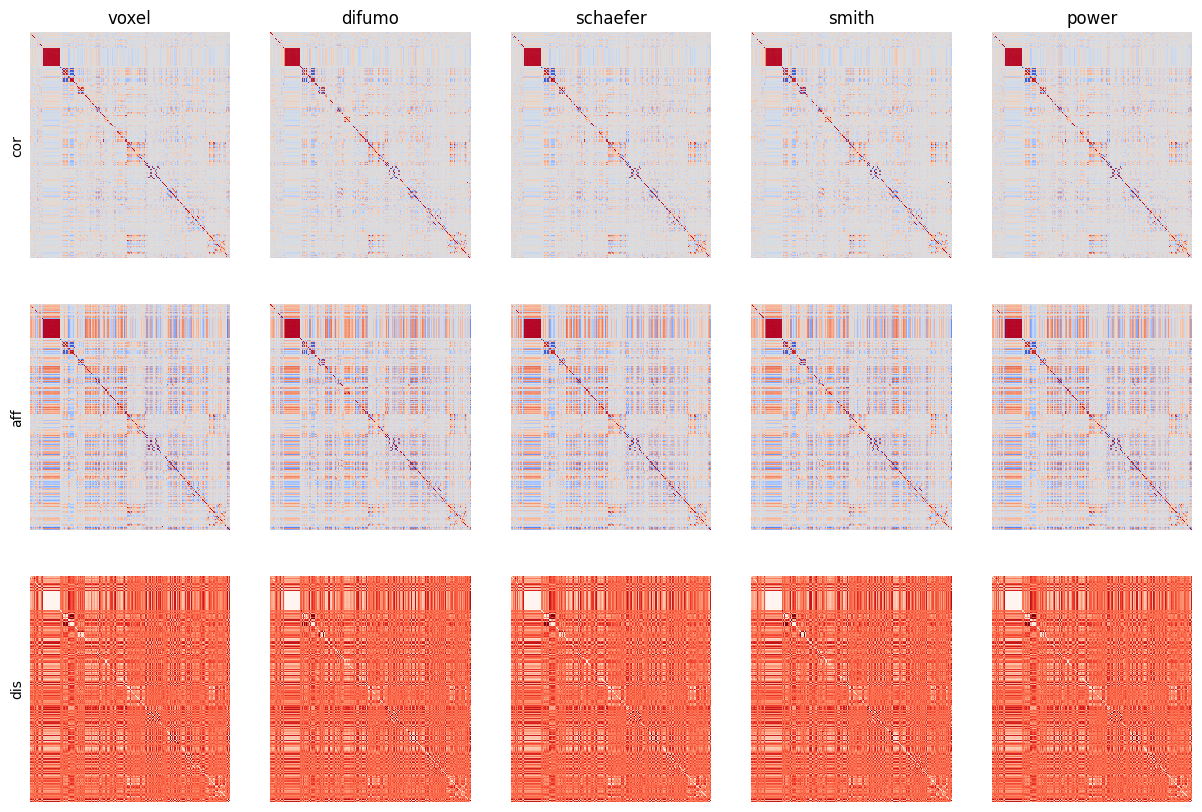

In [10]:
fig, axes = plt.subplots(len(data_types), len(atlases), figsize=(15, 10))

for i, data_type in enumerate(data_types):
    for j, atlas in enumerate(atlases):
        data = np.load(op.join(clustering_dir, f"{atlas}_{data_type}.npy"))
        ax = axes[i, j]

        if data_type == "dis":
            vmin, vmax = 0, 2
            cmap = "Reds"
        else:
            vmin, vmax = -1, 1
            cmap = "coolwarm"

        # cbar = False if j < len(atlases) - 1 else True
        cbar = False

        sns.heatmap(data, cmap=cmap, vmin=vmin, vmax=vmax, cbar=cbar, ax=ax)
        ax.set_xlabel("")
        ax.set_xticks([])
        ax.set_yticks([])

        if i == 0:
            ax.set_title(atlas)
        if j == 0:
            ax.set_ylabel(data_type)
        else:
            ax.set_ylabel("")

fig.savefig(op.join(figures_dir, "heatmaps.png"), bbox_inches="tight", dpi=300)

In [11]:
atlas = "voxel"
voxel_data_df = pd.read_csv(op.join(clustering_dir, f"{atlas}_data.csv"))
voxel_silh_df = pd.read_csv(op.join(clustering_dir, f"{atlas}_silhouette.csv"))

## Dimensionality reduction of the data to visualize it in 2D


In [12]:
fig = px.scatter(voxel_silh_df, x="min_samples", y="score", color="params")
fig.show()

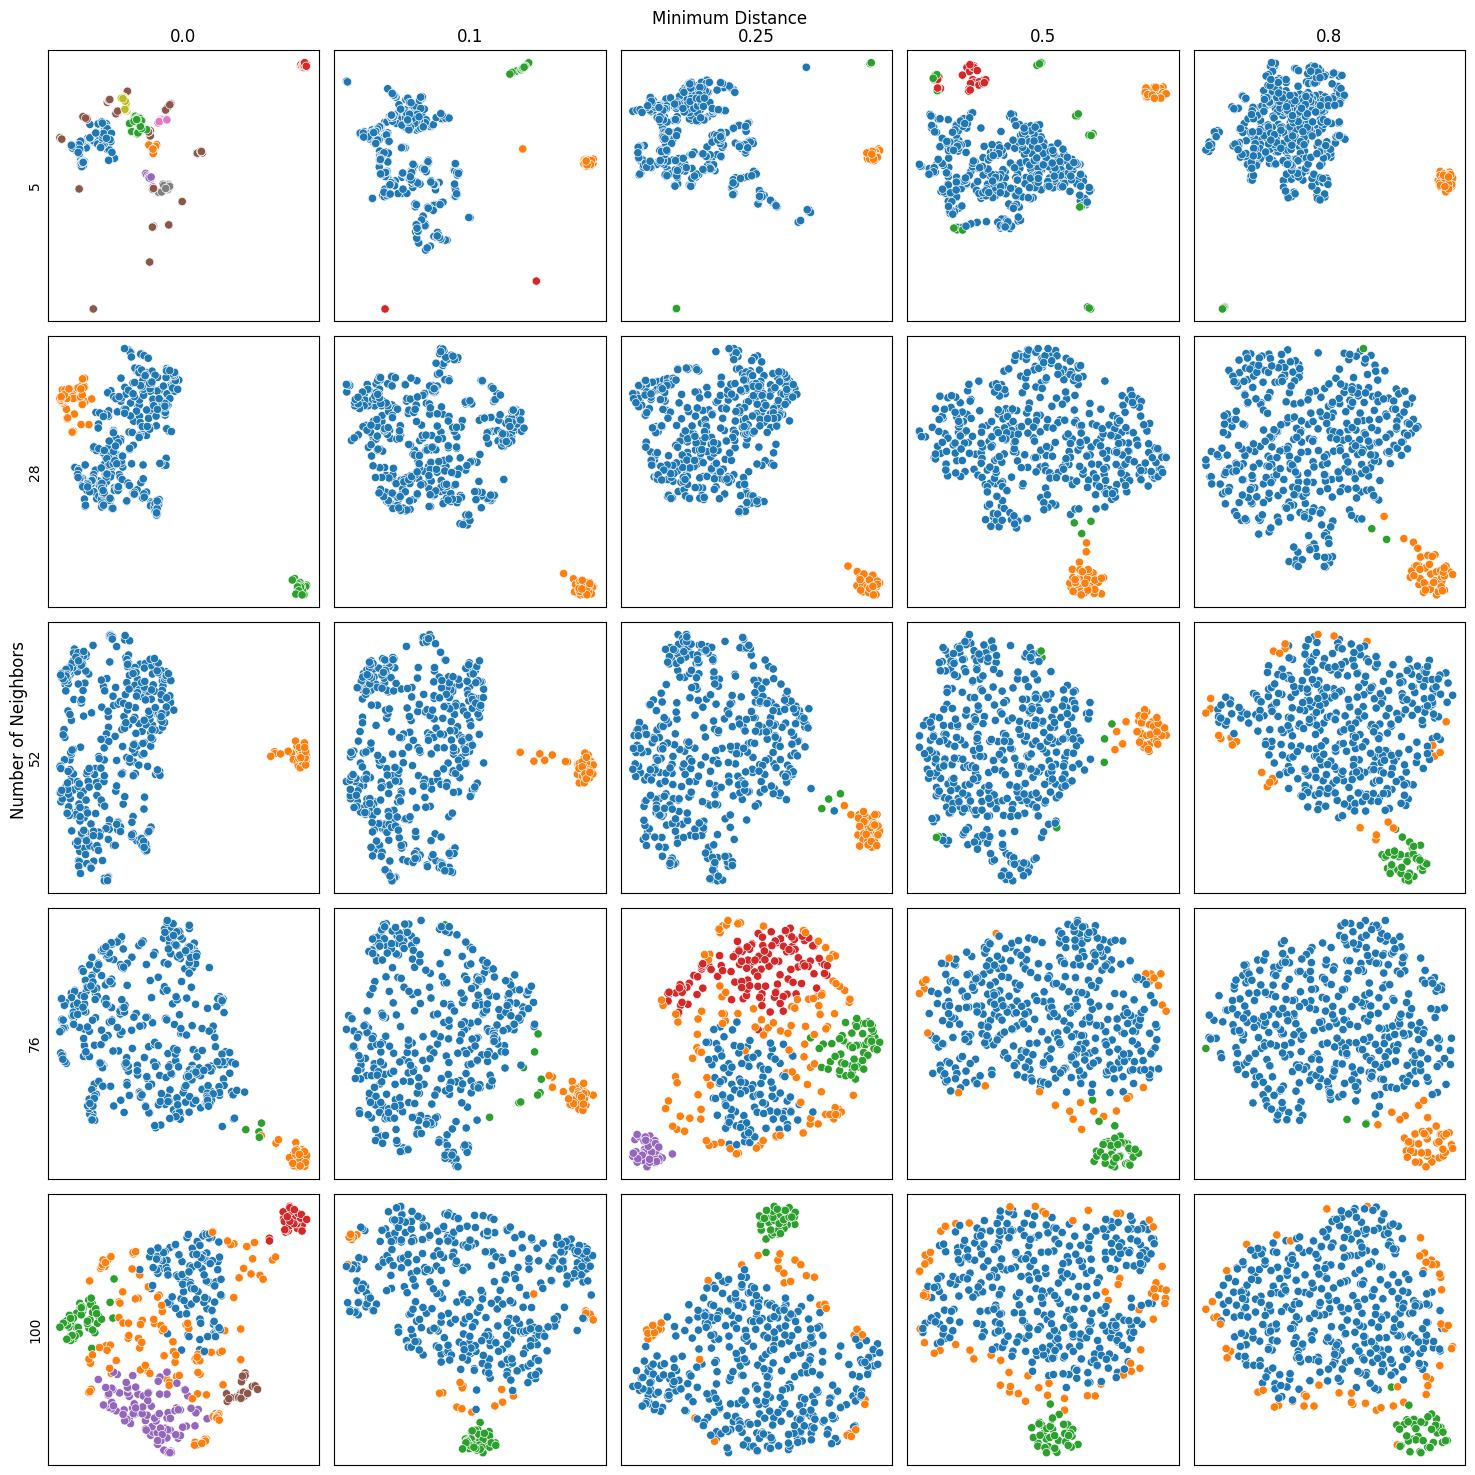

In [23]:
fig, axes = plt.subplots(n_n, n_d, figsize=(n_d * 3, n_n * 3))
n_components = 2
min_samples = 16
for i, n_neighbors in enumerate(neighbors):
    for j, min_dist in enumerate(distances):
        ax = axes[i, j]
        
        ax = _plot_data(voxel_data_df, n_components, n_neighbors, min_dist, min_samples, ax)
        if i == 0:
            ax.set_title(f"{min_dist}")
        if j == 0:
            ax.set_ylabel(f"{n_neighbors}")


fig.suptitle("Minimum Distance")
fig.supylabel("Number of Neighbors")
plt.tight_layout()

fig.savefig(
    op.join(figures_dir, f"{atlas}_neighbors_vs_distances.png"), bbox_inches="tight", dpi=300
)
plt.show()

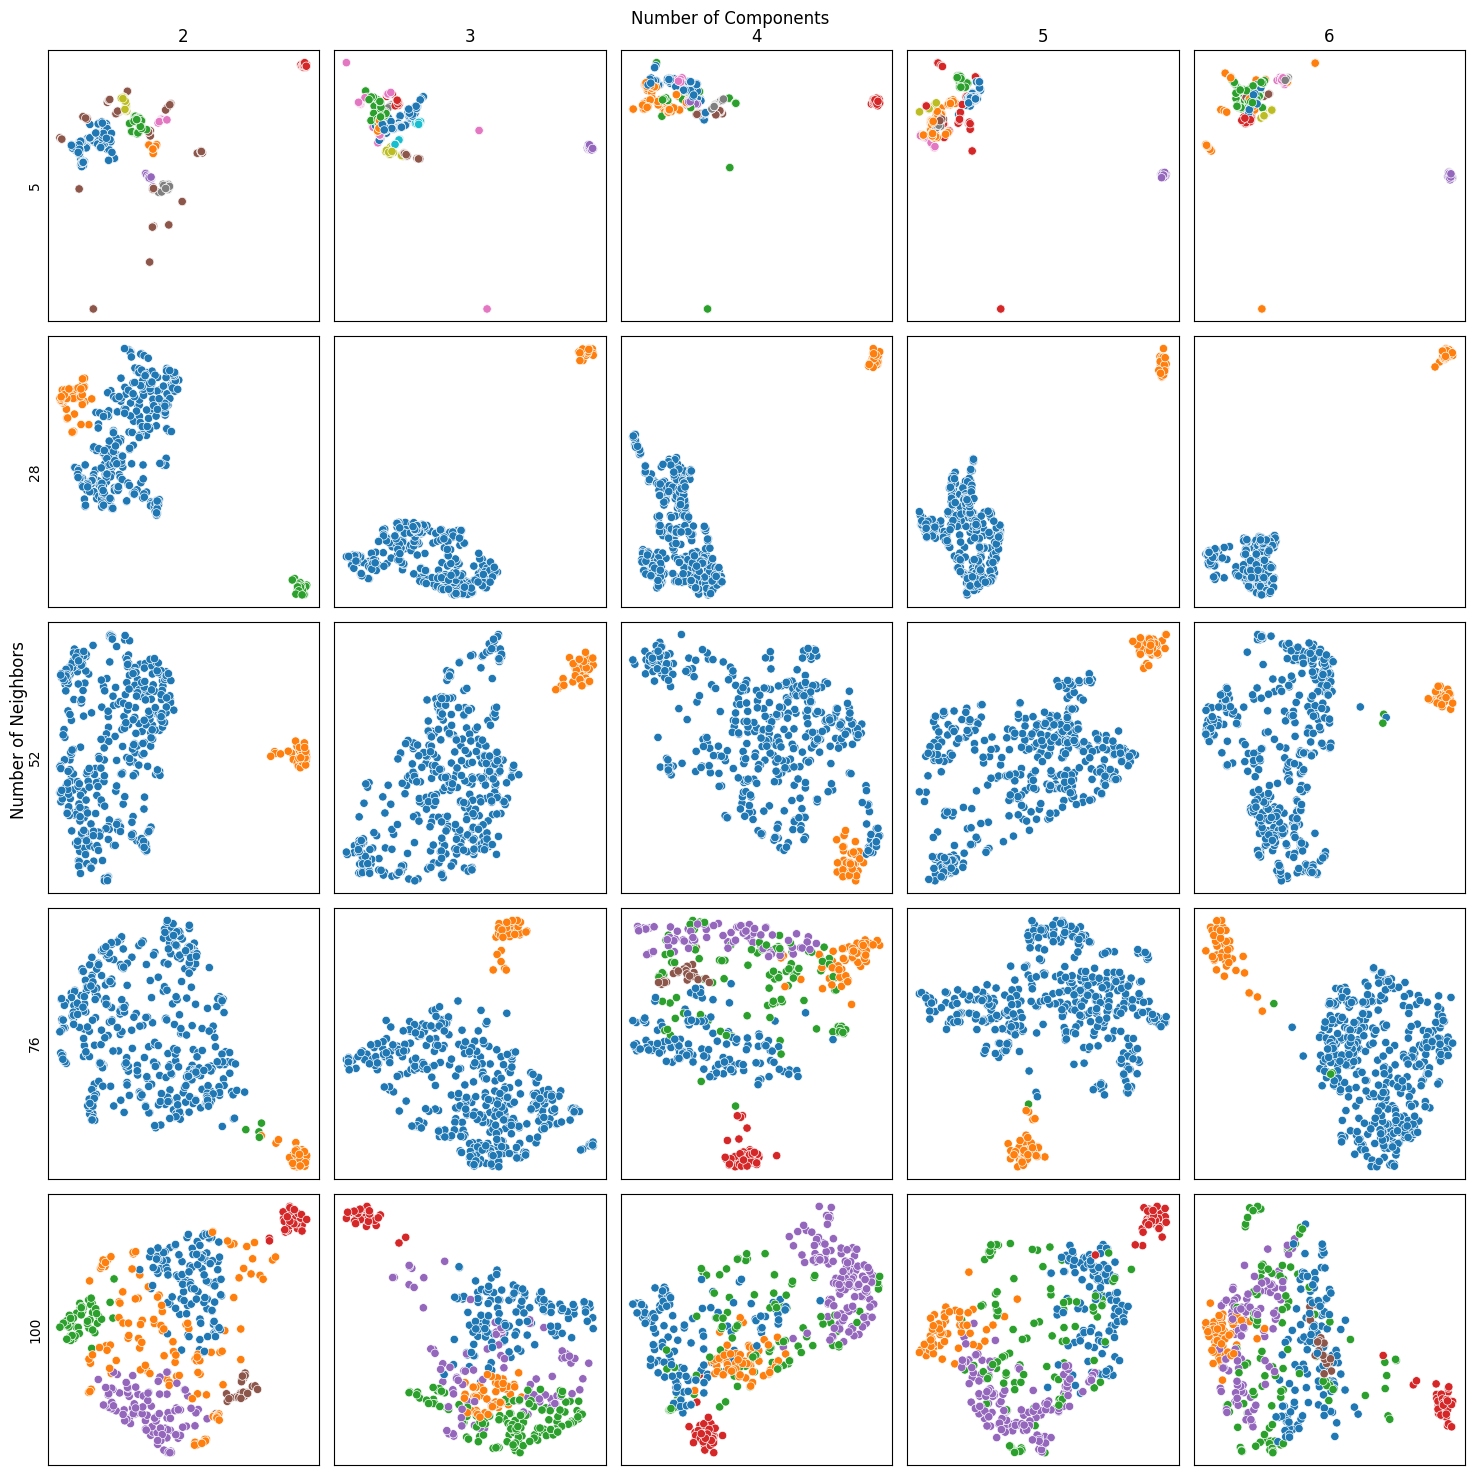

In [24]:
fig, axes = plt.subplots(n_n, n_c, figsize=(n_c * 3, n_n * 3))
min_dist = 0.0
min_samples = 16
for i, n_neighbors in enumerate(neighbors):
    for j, n_components in enumerate(components):
        ax = axes[i, j]

        ax = _plot_data(voxel_data_df, n_components, n_neighbors, min_dist, min_samples, ax)
        if i == 0:
            ax.set_title(f"{n_components}")
        if j == 0:
            ax.set_ylabel(f"{n_neighbors}")

fig.suptitle("Number of Components")
fig.supylabel("Number of Neighbors")
plt.tight_layout()

fig.savefig(
    op.join(figures_dir, f"{atlas}_neighbors_vs_components.png"), bbox_inches="tight", dpi=300
)
plt.show()

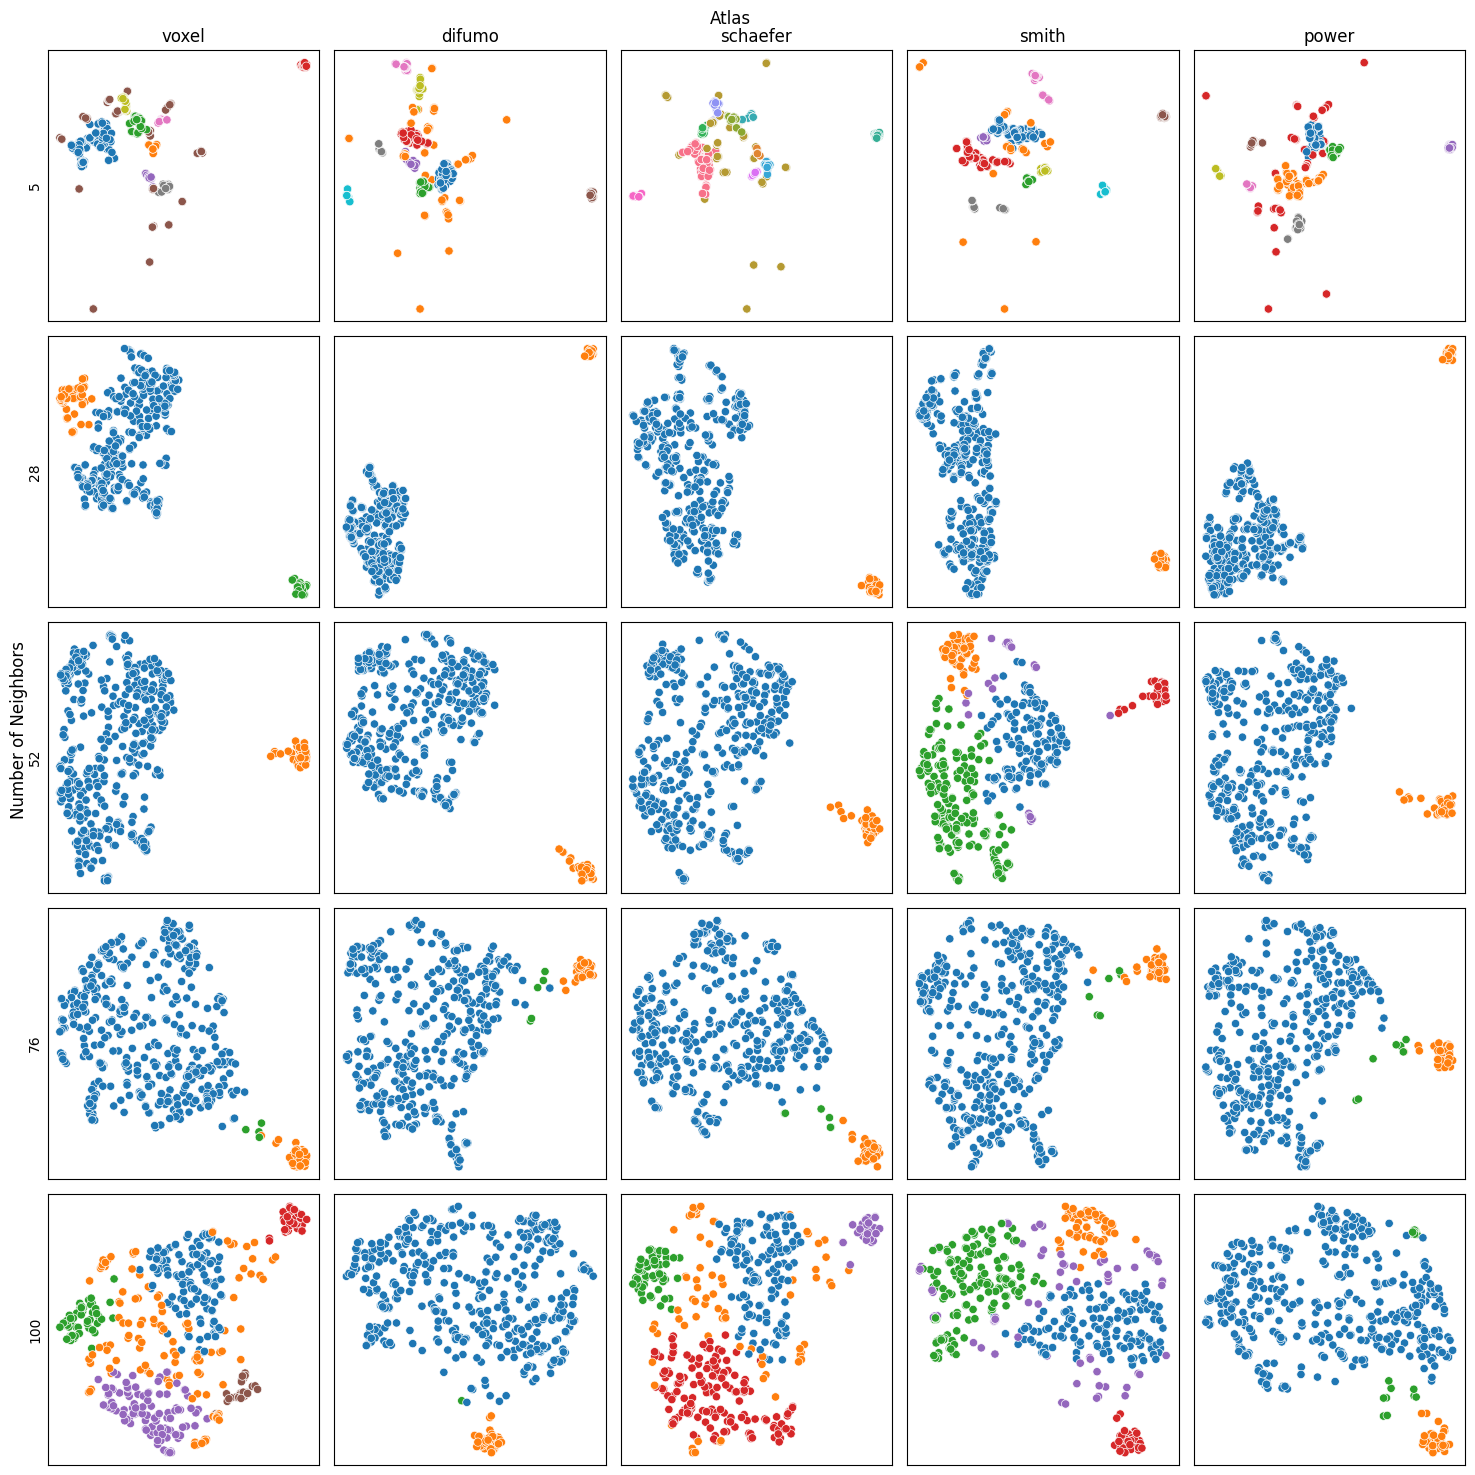

In [25]:
fig, axes = plt.subplots(n_n, n_a, figsize=(n_a * 3, n_n * 3))
min_dist = 0.0
min_samples = 16
n_components = 2
for i, n_neighbors in enumerate(neighbors):
    for j, atlas in enumerate(atlases):
        ax = axes[i, j]

        atlas_data_df = pd.read_csv(op.join(clustering_dir, f"{atlas}_data.csv"))
        ax = _plot_data(atlas_data_df, n_components, n_neighbors, min_dist, min_samples, ax)
        if i == 0:
            ax.set_title(f"{atlas}")
        if j == 0:
            ax.set_ylabel(f"{n_neighbors}")

fig.suptitle("Atlas")
fig.supylabel("Number of Neighbors")
plt.tight_layout()

fig.savefig(
    op.join(figures_dir, "neighbors_vs_atlas.png"), bbox_inches="tight", dpi=300
)
plt.show()

In [26]:
obtimal_col_x = "c-2-0_n-100_d-0.0"
obtimal_col_y = "c-2-1_n-100_d-0.0"
optimal_labels = "hdbscan_c-2_n-100_d-0.0_16"

In [27]:
contrast_names = voxel_data_df["cognitive_paradigm_cogatlas_name"].unique()
labels = sorted(voxel_data_df[optimal_labels].astype(int).unique())
labels_str = [str(label) for label in labels]

data_count_df = pd.DataFrame(columns=["cognitive_paradigm_cogatlas_name", "count", "label"])
for label in labels:
    sub_data_df = voxel_data_df[voxel_data_df[optimal_labels] == str(label)]
    count_df = (
        sub_data_df.groupby("cognitive_paradigm_cogatlas_name").size().sort_values(ascending=False)
    )
    count_df = pd.DataFrame(count_df)
    count_df = count_df.rename(columns={count_df.columns[0]: "count"})
    count_df = count_df.reset_index()
    count_df["label"] = label
    data_count_df = pd.concat([data_count_df, count_df])

count_pivot = data_count_df.pivot(
    index="label", columns="cognitive_paradigm_cogatlas_name", values="count"
)

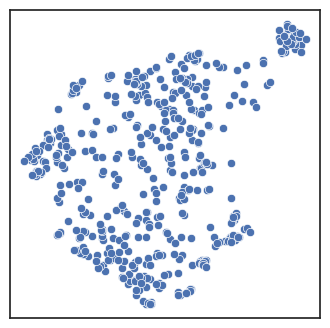

In [41]:
fig, ax = plt.subplots(figsize=(4, 4))
sns.scatterplot(
    voxel_data_df,
    x=obtimal_col_x,
    y=obtimal_col_y,
    legend=False,
    ax=ax,
)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel("")
ax.set_ylabel("")
fig.savefig(op.join(figures_dir, "umap.png"), bbox_inches="tight", dpi=300)

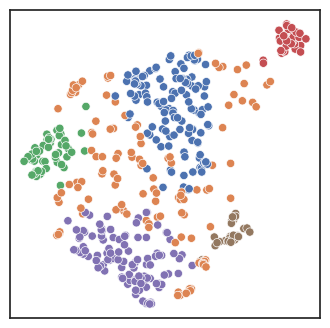

In [47]:
fig, ax = plt.subplots(figsize=(4, 4))
sns.scatterplot(
    voxel_data_df,
    x=obtimal_col_x,
    y=obtimal_col_y,
    hue=optimal_labels,
    legend=False,
    ax=ax,
)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel("")
ax.set_ylabel("")
fig.savefig(op.join(figures_dir, "umap_hdbscan.png"), bbox_inches="tight", dpi=300)

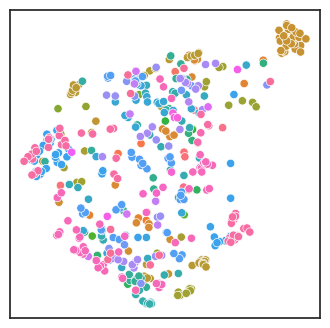

In [42]:
fig, ax = plt.subplots(figsize=(4, 4))
sns.scatterplot(
    voxel_data_df,
    x=obtimal_col_x,
    y=obtimal_col_y,
    hue="pmid",
    legend=False,
    ax=ax,
)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel("")
ax.set_ylabel("")
fig.savefig(op.join(figures_dir, "umap_pmid.png"), bbox_inches="tight", dpi=300)

In [28]:
fig = px.scatter(
    voxel_data_df,
    x=obtimal_col_x,
    y=obtimal_col_y,
    color=optimal_labels,
    color_discrete_sequence=px.colors.qualitative.Alphabet,
)
fig.show()

In [30]:
voxel_data_df["pmid"] = voxel_data_df["pmid"].astype(str)
fig = px.scatter(
    voxel_data_df,
    x=obtimal_col_x,
    y=obtimal_col_y,
    color="pmid",
    color_discrete_sequence=px.colors.qualitative.Alphabet,
)
fig.show()

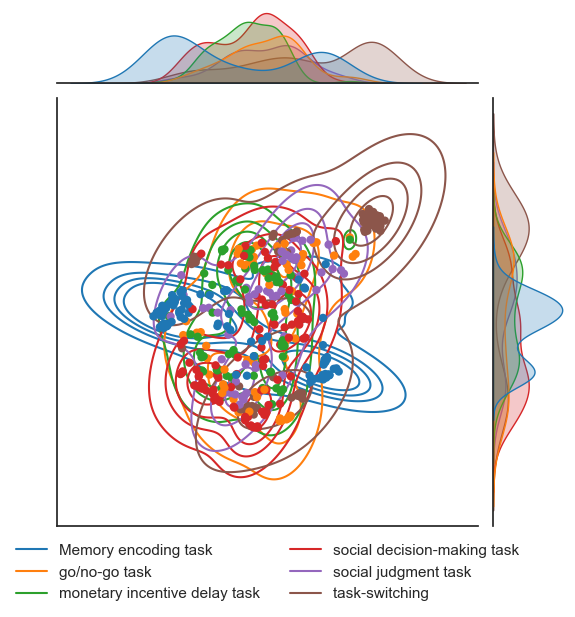

In [43]:
pal = px.colors.qualitative.D3[:6]
g = sns.jointplot(
    data=voxel_data_df,
    x=obtimal_col_x,
    y=obtimal_col_y,
    hue="cognitive_paradigm_cogatlas_name",
    hue_order=count_pivot.columns.to_list(),
    palette=pal,
    alpha=1,
    legend=False,
)
g.plot_joint(sns.kdeplot, palette=pal, zorder=0, levels=5, alpha=1)
sns.move_legend(
    g.ax_joint,
    ncol=2,
    markerscale=0.5,
    loc="upper center",
    title="",
    bbox_to_anchor=(0.5, -0.01),
    frameon=False,
)

# g.ax_joint.get_legend().remove()
g.ax_joint.collections[0].set_edgecolor("none")
g.ax_joint.collections[0].set_linewidth(0)
g.ax_joint.set_xticks([])
g.ax_joint.set_yticks([])
g.ax_joint.set_xlabel("")
g.ax_joint.set_ylabel("")
plt.savefig(op.join(figures_dir, "umap_task.png"), bbox_inches="tight", dpi=300)

/Users/jperaza/Documents/GitHub/large-scale-ibma/env/nv-ibma_env/lib/python3.10/site-packages/seaborn/axisgrid.py:1832: UserWarning:


The palette list has fewer values (10) than needed (11) and will cycle, which may produce an uninterpretable plot.

/Users/jperaza/Documents/GitHub/large-scale-ibma/env/nv-ibma_env/lib/python3.10/site-packages/seaborn/axisgrid.py:1883: UserWarning:


The palette list has fewer values (10) than needed (11) and will cycle, which may produce an uninterpretable plot.

/Users/jperaza/Documents/GitHub/large-scale-ibma/env/nv-ibma_env/lib/python3.10/site-packages/seaborn/axisgrid.py:1889: UserWarning:


The palette list has fewer values (10) than needed (11) and will cycle, which may produce an uninterpretable plot.

/Users/jperaza/Documents/GitHub/large-scale-ibma/env/nv-ibma_env/lib/python3.10/site-packages/seaborn/axisgrid.py:1832: UserWarning:


The palette list has fewer values (10) than needed (11) and will cycle, which may produce an uninterpretable plo

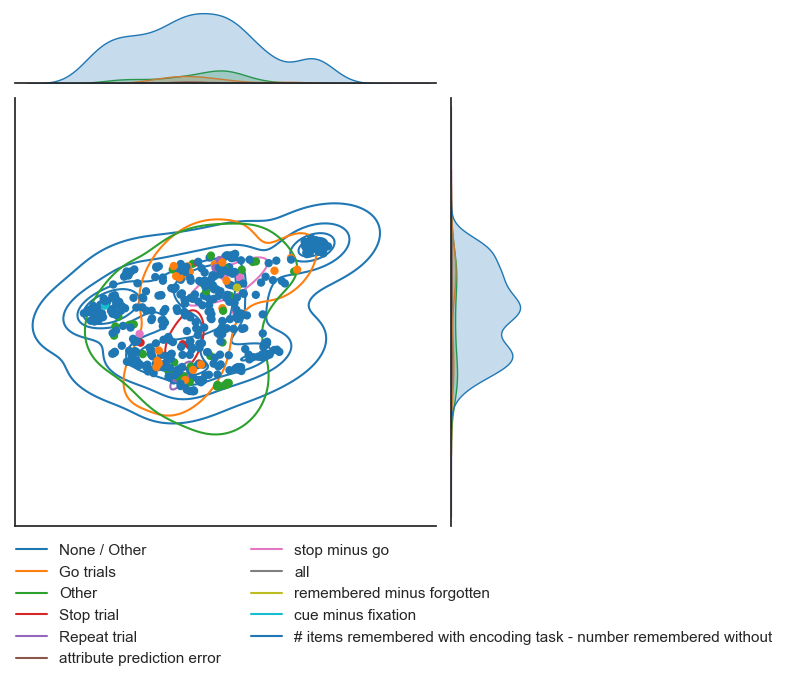

In [44]:
pal = px.colors.qualitative.D3
g = sns.jointplot(
    data=voxel_data_df,
    x=obtimal_col_x,
    y=obtimal_col_y,
    hue="cognitive_contrast_cogatlas_name",
    palette=pal,
    alpha=1,
    legend=False,
)
g.plot_joint(sns.kdeplot, palette=pal, zorder=0, levels=5, alpha=1)
sns.move_legend(
    g.ax_joint,
    ncol=2,
    markerscale=0.5,
    loc="upper center",
    title="",
    bbox_to_anchor=(0.9, -0.01),
    frameon=False,
)

# g.ax_joint.get_legend().remove()
g.ax_joint.collections[0].set_edgecolor("none")
g.ax_joint.collections[0].set_linewidth(0)
g.ax_joint.set_xticks([])
g.ax_joint.set_yticks([])
g.ax_joint.set_xlabel("")
g.ax_joint.set_ylabel("")
plt.savefig(op.join(figures_dir, "umap_contrast.png"), bbox_inches="tight", dpi=300)

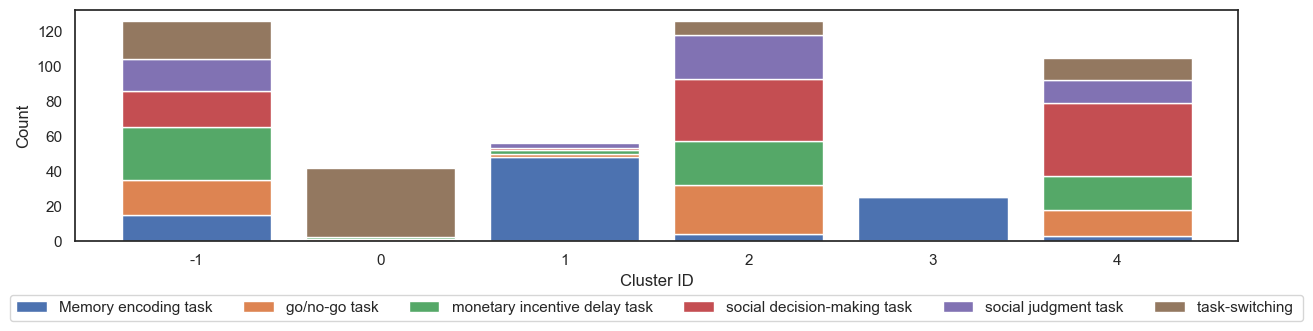

In [45]:
sns.set_theme(style="white")

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(15, 3)

count_pivot.plot.bar(
    rot=0,
    width=0.81,
    stacked=True,
    ax=ax,
)
ax.set_ylabel("Count")
ax.set_xlabel("Cluster ID")
ax.legend(ncol=6, loc="upper center", bbox_to_anchor=(0.5, -0.2), frameon=True)
fig.savefig(op.join(figures_dir, "umap_hdbscan16_task.png"), bbox_inches="tight", dpi=300)
plt.show()

/Users/jperaza/Documents/GitHub/large-scale-ibma/env/nv-ibma_env/lib/python3.10/site-packages/seaborn/axisgrid.py:1832: UserWarning:

The palette list has more values (11) than needed (6), which may not be intended.

/Users/jperaza/Documents/GitHub/large-scale-ibma/env/nv-ibma_env/lib/python3.10/site-packages/seaborn/axisgrid.py:1883: UserWarning:

The palette list has more values (11) than needed (6), which may not be intended.

/Users/jperaza/Documents/GitHub/large-scale-ibma/env/nv-ibma_env/lib/python3.10/site-packages/seaborn/axisgrid.py:1889: UserWarning:

The palette list has more values (11) than needed (6), which may not be intended.

/Users/jperaza/Documents/GitHub/large-scale-ibma/env/nv-ibma_env/lib/python3.10/site-packages/seaborn/axisgrid.py:1832: UserWarning:

The palette list has more values (11) than needed (6), which may not be intended.



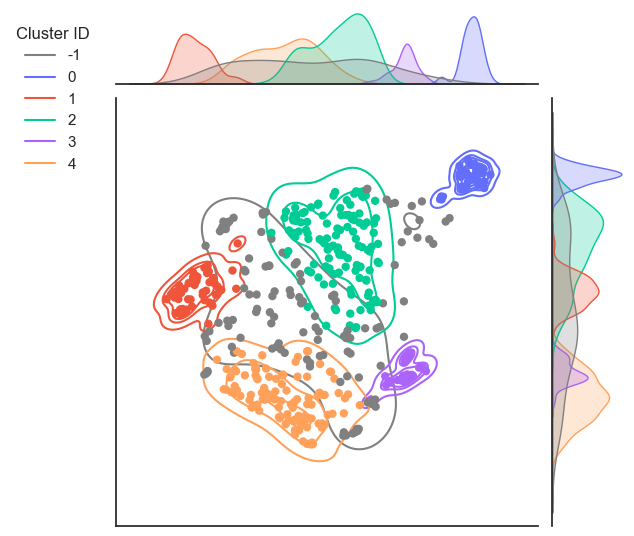

In [46]:
pal = px.colors.qualitative.Plotly[:22]
pal.insert(0, "grey")
g = sns.jointplot(
    data=voxel_data_df,
    x=obtimal_col_x,
    y=obtimal_col_y,
    hue=optimal_labels,
    hue_order=labels_str,
    palette=pal,
    alpha=1,
    legend=False,
)
g.plot_joint(sns.kdeplot, palette=pal, zorder=0, levels=5, alpha=1)
sns.move_legend(
    g.ax_joint,
    ncol=1,
    markerscale=0.5,
    loc="upper center",
    title="Cluster ID",
    bbox_to_anchor=(-0.15, 1.2),
    frameon=False,
)

# g.ax_joint.get_legend().remove()
g.ax_joint.collections[0].set_edgecolor("none")
g.ax_joint.collections[0].set_linewidth(0)
g.ax_joint.set_xticks([])
g.ax_joint.set_yticks([])
g.ax_joint.set_xlabel("")
g.ax_joint.set_ylabel("")
plt.savefig(op.join(figures_dir, "umap_hdbscan16.png"), bbox_inches="tight", dpi=300)

In [38]:
pmids = voxel_data_df["pmid"].unique()
focus_counts_df = pd.DataFrame(index=pmids)

for label in labels_str:
    sub_data_df = voxel_data_df[voxel_data_df[optimal_labels] == str(label)]
    count_df = sub_data_df.groupby("pmid").size()
    count_df = pd.DataFrame(count_df)
    count_df = count_df.rename(columns={count_df.columns[0]: label})
    focus_counts_df = pd.merge(
        focus_counts_df, count_df, how="left", left_index=True, right_index=True
    )
    
focus_counts_df = focus_counts_df.fillna(0)

In [39]:
fig = px.imshow(focus_counts_df, color_continuous_scale="Reds", zmin=0, aspect="equal")
fig.update_layout(autosize=True, height=focus_counts_df.shape[0] * 20)